In [1]:
%config Completer.use_jedi = False

In [2]:
from utils import *
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "../datasets/UK10_1.txt"
meta_data, distance_data, station_data = parse_UK_Data(dataset)

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context,to_csv=True,filename=dataset)
station_coordinates = pd.read_csv('../datasets/UK10_1_coordinates.csv', encoding='utf-8')
points_coordinate = station_coordinates[["lat", "long"]].to_numpy()

#UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")

In [3]:
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
distance_matrix_here,time_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)

## Fuel consumption function from "*A Hybrid Tabu Search Algorithm for a Real-World Open Vehicle Routing Problem Involving Fuel Consumption Constraints" by Niu et al.*"

### $F^{h} = \lambda(\frac{k^{h}N^{h}V^{h}d}{v} + M^{h}\gamma^{h}\alpha d + \beta^{h}\gamma^{h}dv^{2})$
### Where for vehicle $h$:
* $F$ = Fuel consumption
* $\lambda = \frac{\xi}{\kappa\psi}$
* $\gamma = \frac{1}{1000n_{tf}\eta}$
* $\alpha = \tau+g sin\theta + gC_{r}cos\theta$
    * $\theta$ = Angle between vehile and road, assumed to be 0 in this case 
* $\beta = 0.5C_{d}A\rho$
* $M$ = total vehicle weight
* $d$ = distance
* $v$ = vehicle speed




| Notation   |      Description      |  Typical values |
|----------|:-------------:|:------:|
| $\xi$ |  Fuel-to-air mass ratio | 1  |
| $g$ |    Gravitational constant ($m/s^2$)|    9.81 |
| $\rho $| Air density ($kg/m^3$) |  1.2041 |
| $\eta$ | Efficiency parameter for diesel engines | 0.45 |
| $C^h_r$ | Coefficient of rolling resistance | 0.01 |
| $\kappa$ | Heating value of a typical diesel fuel (kj/g) | 44 |
| $\psi$ | Conversion factor (g/s to L/s) | 737 |
| $n_{tf}$ | Vehicle drive train efficiency | 0.45 |
| $\tau$ | Acceleration ($m/s^2$) | 0 |


| Notation   |      Description      |  Light duty |  Medium duty |  Heavy duty |
|----------|:-------------:|:------:|:------:|:------:|
|$\omega$ | Curb weight (kg) | 3500 | 5500 | 14000|
|$Q$ | Maximum payload (kg) | 4000 | 12500 | 26000 |
| $k$ | Engine friction factor (kj/rev/liter) | 0.25 | 0.20 | 0.15 |
| $N$ | Engine speed (rev/s) | 38.34 | 36.67 | 30.0 |
| $V$ | Engine displacement (liter) | 4.5 | 6.9 | 10.5 |
| $C_d$ | Coefficient of aerodynamics drag | 0.6 | 0.7 | 0.9 |
| $A$ | Frontal surface area ($m^2$) | 7.0 | 8.0 | 10.0 |

In [7]:
niu_constants_light_vehicle = {
    "fuel_to_air_ratio":1,
    "g":9.81,
    "air_density": 1.2041,
    "frontal_surface_area": 7,
    "rolling_resistance": 0.01,
    "aerodynamics_drag": 0.6,
    "conversion_factor":737,
    "heating_value":44,
    "vehicle_drive_train": 0.45,
    "efficiency_diesel":0.45,
    "engine_friction": 0.25,
    "engine_speed": 38.34,
    "engine_displacement": 4.5
    
}
# Angle to ground is constantly assumed to be 0
niu_constants_light_vehicle["alpha"] = niu_constants_light_vehicle["g"] * niu_constants_light_vehicle["rolling_resistance"]

niu_constants_light_vehicle["lambda"] = niu_constants_light_vehicle["fuel_to_air_ratio"]/(niu_constants_light_vehicle["heating_value"]*niu_constants_light_vehicle["conversion_factor"])

niu_constants_light_vehicle["gamma"] = niu_constants_light_vehicle["efficiency_diesel"]/(1000*niu_constants_light_vehicle["vehicle_drive_train"])

niu_constants_light_vehicle["beta"] = 0.5* niu_constants_light_vehicle["aerodynamics_drag"]  * niu_constants_light_vehicle["frontal_surface_area"]  * niu_constants_light_vehicle["air_density"] 

In [8]:
def fuel_consumption_niu(from_node,to_node,distance_matrix,time_matrix,demands,vehicle_weight):
    distance = distance_matrix[from_node][to_node]
    
    demand = demands[from_node]
    
    current_speed = distance/time_matrix[from_node][to_node]
    curb_weight =  demand + vehicle_weight

    first_term = (niu_constants_light_vehicle["engine_friction"] * niu_constants_light_vehicle["engine_speed"] * niu_constants_light_vehicle["engine_displacement"] * distance)/current_speed

    second_term = curb_weight * niu_constants_light_vehicle["gamma"] * niu_constants_light_vehicle["alpha"]*distance
    
    third_term = niu_constants_light_vehicle["beta"] * niu_constants_light_vehicle["gamma"] * distance * (current_speed**2)
    
    fuel_consumption = niu_constants_light_vehicle["lambda"] * (first_term + second_term + third_term)
    
    print(first_term * niu_constants_light_vehicle["lambda"])
    print(second_term * niu_constants_light_vehicle["lambda"])
    print(third_term * niu_constants_light_vehicle["lambda"])
    
    
    return fuel_consumption
    
#fuel_consumption_niu(0,2,distance_matrix_here,time_matrix_here,customer_demands,3000)

In [9]:
distance_matrix_here

,0,1,2,3,4,5,6,7,8,9,10
0,0,45436,207112,60243,199149,18881,98595,355274,336346,94662,70883
1,41374,0,162009,40816,330198,43528,94453,346136,327208,90520,28043
2,206972,161766,0,145180,427976,205415,174809,443914,424986,165338,124482
3,59852,39266,147999,0,306560,58295,56330,322498,303570,52397,34495
4,195906,237796,357809,220004,0,179511,226886,90070,31561,235817,255397
5,18498,44261,205937,59068,193895,0,90488,348142,228923,93487,69708
6,98950,89838,169037,50943,283088,87110,0,299026,280098,9101,81099
7,356334,347222,444568,329430,90529,354777,299620,0,84501,308551,356060
8,337503,351012,425737,307643,31638,330205,280789,83971,0,289720,337229
9,94723,90085,164810,46716,291068,93166,8767,307006,288078,0,76872


In [10]:
#===========================
#https://reader.elsevier.com/reader/sd/pii/S1361920911000782?token=28C5EA5FCAC2E33C438A25D8EC45D5FC04E7D546F5AFFDE134D24EBF66D9C9E3078F79669438F3BDCB2A2A10F67BFD12
# Air density at 15C, kg/m³
air_density = 1.2256
# Vehicle drag coefficient (unitless)
drag = 0.35
# Rolling coefficients (unitless)
rolling_coeff = 1.75
# Road condition
c1 = 0.0328
# Tire type
c2 = 4.575
# Driveline efficiency
driveline_eff = 0.85
# Tire slippage
slippage = 0.03

#===========================

# Vehicle frontal area, m²
#http://segotn12827.rds.volvo.com/STPIFiles/Volvo/ModelRange/fh42t3a_swe_swe.pdf
frontal_area = 8

# Number of revolutions (rps)
# https://stpi.it.volvo.com/STPIFiles/Volvo/FactSheet/D13%20460T,%20EU6HT_Swe_01_310999629.pdf
no_revolution = 1200/60
#https://www.preem.se/contentassets/63186d81c7f742d4860d02da8ebea8fd/preem-evolution-diesel.pdf
# kg/l
diesel_density = 0.826
#https://www.volvotrucks.us/-/media/vtna/files/shared/powertrain/revised4147_101-volvo_d13_engine-brochure_low-res.pdf
# Volume, dm²
engine_displacement = 12.8
torque = 2300
# https://stpi.it.volvo.com/STPIFiles/Volvo/FactSheet/D13K460,%20EU6SCR_Swe_08_307895068.pdf
engine_breaking_effect = 375
# Calculates the mean effective pressure
# https://en.wikipedia.org/wiki/Mean_effective_pressure
mean_effective_pressure = 2*np.pi*2*(torque/engine_displacement)
# Calculates the internal engine friction
# https://www.diva-portal.org/smash/get/diva2:669227/FULLTEXT01.pdf
engine_internal_friction = (mean_effective_pressure * 4 * engine_displacement * no_revolution)/1000


In [52]:
def fuel_consumption_rakha(from_node,to_node,distance_matrix,time_matrix,demands,vehicle_weight):
    """
    Returns the estimated fuel consumption between two nodes.
    Assumes an acceleration and road gradient of 0
    Based on 'Virginia Tech Comprehensive Power-Based Fuel Consumption Model:Model development and testing' by Rakha et al. (2011) 
    Rakha et al. mentiones the follwing source:
    https://books.google.se/books?hl=sv&lr=&id=Blp2D1DteTYC&oi=fnd&pg=PR11&dq=Theory+of+Ground+Vehicles+J.Y.+Wong&ots=Xump_f09hf&sig=SMj4XXTZlJYlep9qNLTltx4zFHg&redir_esc=y
    """
    
    distance = distance_matrix[from_node][to_node]
    
    demand = demands[from_node]
    
    current_speed = distance/time_matrix[from_node][to_node]
    specific_fuel_consumption = diesel_density * (meta_data["F-C Empty (l/100km)"]/1e5)*current_speed/engine_breaking_effect
    
    current_speed_km_h = current_speed * 3.6
    curb_weight =  demand + vehicle_weight
    g = 9.8066
    
    
    R = (air_density/25.92) * drag * frontal_area * current_speed_km_h**2 + g * curb_weight * (rolling_coeff/1000) * (c1 * current_speed_km_h + c2)
    
    P = R/(3600*0.45) * current_speed_km_h
    
    F = specific_fuel_consumption * (((engine_internal_friction * no_revolution * engine_displacement)/2000) + P)
    
    fuel_consumption  = F*time_matrix[from_node][to_node]

    
    return np.float(fuel_consumption)
    


In [53]:

def demand_callback(from_node,demands):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    # from_node = manager.IndexToNode(from_index)
    return demands[from_node]

# Create and register a transit callback.
def distance_callback(from_index, to_index,distance_matrix):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    return distance_matrix[from_index][to_index]

# Try this with adding previous load weights, would be done with an additional parameter of previous loads
def fuel_consumption_callback(from_node, to_node,distance_matrix,demands):
    
    """Returns the estimated fuel consumption between two nodes.
    Based on 'A Fuel Consumption Objective of VRP and the Genetic Algorithm' by Hao Xiong"""
    #Distance in 100km
    distance = (distance_matrix[from_node][to_node])/1e5
    #Demand in kg
    demand = demands[from_node]
    #Fuel consumption between nodes driving empty vehicle
    fuel_consumption_empty = distance * meta_data['F-C Empty (l/100km)']
    load_rate = demand / float(meta_data['Max Load(kg)'])
    #Additional fuel consumption when adding load at from_index
    fuel_consumption_load = distance * load_rate * (meta_data['F-C Full (l/100km)'] - meta_data['F-C Empty (l/100km)'])
    return np.float(fuel_consumption_empty + fuel_consumption_load)
    


In [100]:
import math
import random
from jmetal.core.problem import PermutationProblem
from jmetal.core.solution import PermutationSolution
from itertools import chain
class VRP(PermutationProblem):
    
    def __init__(self,problemData):
        check_type(problemData,dict)
        super(VRP,self).__init__()
        
        self.distance_matrix = problemData['distance_matrix']
        self.time_matrix = problemData['time_matrix']
        self.demands = problemData['demands']
        self.max_no_of_vehicle = problemData['vehicle_amount']
        self.vehicle_capacities = problemData['vehicle_capacities']
        self.object_directions=[self.MINIMIZE,self.MINIMIZE]
        self.number_of_objectives = problemData['objective_amount']
        self.objective_functions=problemData['objective_functions']
        self.objective_labels = problemData['objective_labels']
        self.number_of_constraints = problemData['constraint_amount']
        self.constraint_functions= problemData['constraint_functions']
        self.number_of_variables = problemData['number_of_cities']
        self.start_positions = problemData['start_points']
        self.end_positions = problemData['end_points']
        self.depot = 0
        self.cost_history = []

    
    def evaluate(self, solution: PermutationSolution) -> PermutationSolution:
        fitness = 0
        permutation = solution.variables
        # Start positions = [0,6] -> paths = [[0],[6]]
        paths = list([[x] for x in self.start_positions])
        vehicles = 1
        current_load = 0
        vehicle_index=0
        
        
        #======================Construct paths==========================#
        for node_index in permutation:
            if not node_index in self.start_positions:
                load = current_load + demand_callback(node_index,self.demands)

                if load <= self.vehicle_capacities[vehicle_index]:
                    paths[vehicle_index].append(node_index)
                    current_load = load

                else:
                    if vehicle_index +1 == self.max_no_of_vehicle:
                        print("COULD NOT WITHOLD LOAD CONSTRAINT")
                        break
                        
                    vehicles +=1
                    vehicle_index+=1
                    # Either set the load to the routes first node
                    # And add the node to the new vehicle
                    current_load = demand_callback(node_index,self.demands)
                    paths[vehicle_index].append(node_index)
                    
                    # Or reset current load and decrement the node_index
                    #current_load = 0
                    #node_index-=1
                    
        solution.path=paths
        #================================================================#
        
        
        #======================CALCULATE FITNESS=========================#
        vehicle_empty_weight = 3000
        solution.vehicle_loads = []
        solution.vehicle_fuel_consumptions = []
        solution.vehicle_route_distances = []
        solution.vehicle_route_times = []
        
        
        dist = 0
        for vehicle_route in paths:
            vehicle_load = 0
            vehicle_fuel_consumption = 0
            vehicle_route_distance = 0
            vehicle_route_time = 0
            for node_index in range(len(vehicle_route)-1):
                from_node = vehicle_route[node_index]
                to_node = vehicle_route[node_index + 1]
                
                vehicle_load += demand_callback(from_node,self.demands)
                vehicle_route_distance += self.distance_matrix[from_node][to_node]
                vehicle_route_time += self.time_matrix[from_node][to_node]
                
                
                #vehicle_fuel_consumption += fuel_consumption_callback(from_node=from_node,to_node=to_node,distance_matrix=self.distance_matrix,demands=self.demands)
#                 vehicle_fuel_consumption += fuel_consumption_niu(from_node=from_node,to_node=to_node,
#                                                                  distance_matrix=self.distance_matrix,time_matrix= self.time_matrix,
#                                                                  demands=self.demands,vehicle_weight=3000)
                
                vehicle_fuel_consumption += fuel_consumption_rakha(from_node=from_node,to_node=to_node,
                                                                 distance_matrix=self.distance_matrix,time_matrix= self.time_matrix,
                                                                 demands=self.demands,vehicle_weight=vehicle_empty_weight + vehicle_load)
            
            #Increment fitness value
            fitness += vehicle_fuel_consumption
            dist += vehicle_route_distance
            solution.vehicle_route_distances.append(round(vehicle_route_distance,2))
            solution.vehicle_fuel_consumptions.append(round(vehicle_fuel_consumption,2))
            solution.vehicle_route_times.append(vehicle_route_time)
            solution.vehicle_loads.append(vehicle_load)
        #=================================================================#
        
        #============CHECK CONSTRAINTS==============
        
        # All nodes must be visited
        if not self.__allVisited(permutation,paths):
            fitness += 10e10   
        
        
        # If end nodes are set, all paths must end at the one of the end nodes
        if self.end_positions != None:
            final_path_positions = self.__getLastNodes(paths)

            all_except_last_position = [path[:-1] for path in paths]

            if not (self.__checkEndPoints(final_path_positions) and self.__containsNoEndPoints(all_except_last_position)):
                fitness += 10e10

        # Add drive time constraint
        
        # If cumulative drive time > 8 hours, add 10e10 to fitness
        #===========================================
        
        # Update objective fitness
        self.cost_history.append(fitness)
        solution.objectives[0] = fitness
        solution.objectives[1] = dist#max(solution.vehicle_route_time)
        return solution
    
    def __checkEndPoints(self,ends):
        return set(ends).issubset(set(self.end_positions))
    
    def __containsNoEndPoints(self,paths):
        return set(self.end_positions).isdisjoint(set(chain.from_iterable(paths)))
    
    def __getLastNodes(self,lst): 
        return list(zip(*[reversed(el) for el in lst]))[0] 
    
    def __allVisited(self,variables,paths):
        return set(variables).issubset(set(chain.from_iterable(paths)))
    
    def get_route(self, solution: PermutationSolution) -> PermutationSolution:
        routes = []
        for index in range(len(solution.path) - 1):
            if solution.path[index] == 0 :
                routes.append([0])
            else:
                routes[-1].append(solution.path[index])
                

        return routes
    
    def create_solution(self) -> PermutationSolution:
        new_solution = PermutationSolution(number_of_variables=self.number_of_variables,number_of_objectives=self.number_of_objectives)
        
        #new_solution.variables =  [0, 1, 3, 6, 8, 9, 17, 18, 20, 2, 4, 10, 11, 5, 7, 12, 13, 14, 15, 16, 19]##list(pd.DataFrame(points_coordinate[range(self.number_of_variables)]).sort_values([0,1]).index.values)
        new_solution.variables = random.sample(range(self.number_of_variables), k=self.number_of_variables)
        return new_solution
        
    def get_name(self):
        return 'VRP'

In [101]:

starts =[0,6]
vehicle_amount = len(starts)

customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[starts] = 0
#customer_demands[ends] = 0
customer_demands = customer_demands.tolist()

vehicle_capacities = [meta_data['Max Load(kg)'].astype(int)[0] for x in range(vehicle_amount)]


distance_matrix = distance_matrix_here#make_open_problem(distance_matrix_here,starts)

#distance_matrix = make_open_problem(squareform(pdist(points_coordinate)),starts)

#depot = 0


data_model_input = {'distance_matrix':distance_matrix,'time_matrix':time_matrix_here,'vehicle_amount':vehicle_amount,
                   'demands':customer_demands,'vehicle_capacities':vehicle_capacities,
                    'objective_amount':2,'objective_labels':['Fuel','Dist'],'constraint_amount':1,
                    'objective_functions':[],'constraint_functions':[],
                    'number_of_cities':distance_matrix.shape[0],
                    'start_points':starts,'end_points':None}



# data_model_input = {'distance_matrix':distance_matrix,'vehicle_amount':vehicle_amount,
#                    'customer_demands':customer_demands,'vehicle_capacities':vehicle_capacities,'depot':depot}


In [102]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory
from jmetal.algorithm.singleobjective import SimulatedAnnealing,GeneticAlgorithm
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.selection import Selection
from jmetal.operator import BinaryTournamentSelection, PolynomialMutation, SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from datetime import datetime
problem_NSGAIII = VRP(data_model_input)
max_evaluations = 5000


# algorithm = SimulatedAnnealing(problem=problem,
#                                mutation=PermutationSwapMutation(1 / problem.number_of_variables),
#                                termination_criterion=StoppingByEvaluations(max_evaluations))

algorithm_NSGAIII=NSGAIII(problem=problem_NSGAIII,
                   population_size=100,
                   reference_directions=UniformReferenceDirectionFactory(2, n_points=100),
                   mutation=PermutationSwapMutation(0.1),
                   crossover=PMXCrossover(0.9),
                   termination_criterion=StoppingByEvaluations(max_evaluations),population_evaluator=MultiprocessEvaluator())

start_time = datetime.now() 
algorithm_NSGAIII.run()
run_time = datetime.now() - start_time

solutions_NSGAIII = algorithm_NSGAIII.get_result()
print("Run time: {}".format(run_time))

Run time: 0:00:06.540841


In [103]:
get_results(solutions_NSGAIII[0].path,problem_NSGAIII.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L),Avg Estimated Fuel Conspumtion (L/100km),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,342.703,2702,44.028851,1.284752,60.447369,20410,05:40:10.00
1,398.620,1587,50.333564,1.262695,70.726072,20290,05:38:10.00


In [104]:
from jmetal.algorithm.multiobjective.nsgaii import NSGAII
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII
from jmetal.algorithm.singleobjective import SimulatedAnnealing,GeneticAlgorithm
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.selection import Selection
from jmetal.operator import BinaryTournamentSelection, PolynomialMutation, SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from datetime import datetime
problemGA = VRP(data_model_input)
max_evaluations = 20000

algorithmGA = GeneticAlgorithm( problem=problemGA,
        population_size=100,
        offspring_population_size=100,
        mutation=PermutationSwapMutation(1 / problemGA.number_of_variables),
        crossover=PMXCrossover(0.9),
        selection=BestSolutionSelection(),
        termination_criterion=StoppingByEvaluations(max_evaluations=5000),
        population_evaluator=MultiprocessEvaluator()
        )
start_time = datetime.now() 
algorithmGA.run()
run_time = datetime.now() - start_time
solutionsGA = algorithmGA.get_result()
solutionsGA.objectives

[72.59846978824676, 754438]

In [105]:
get_results(solutionsGA.path,problemGA.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L),Avg Estimated Fuel Conspumtion (L/100km),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,342.703,2702,44.028851,1.284752,60.447369,20410,05:40:10.00
1,415.165,1844,52.389710,1.261901,72.697797,20559,05:42:39.00


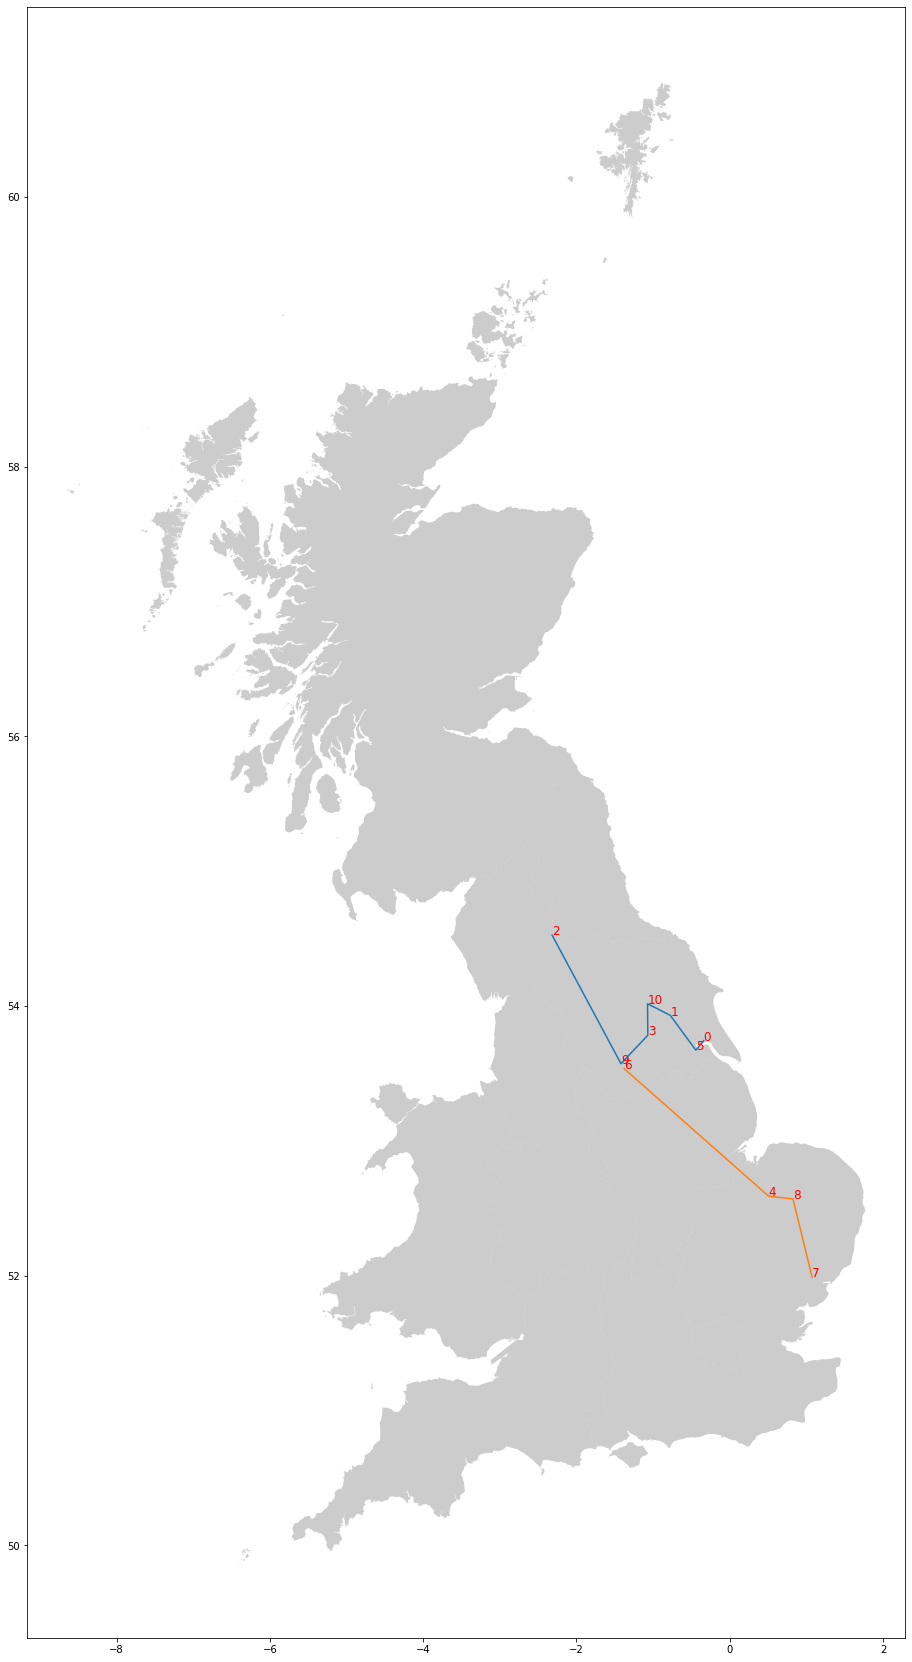

In [108]:
plot_routes(solutions_NSGAIII[0].path,points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)

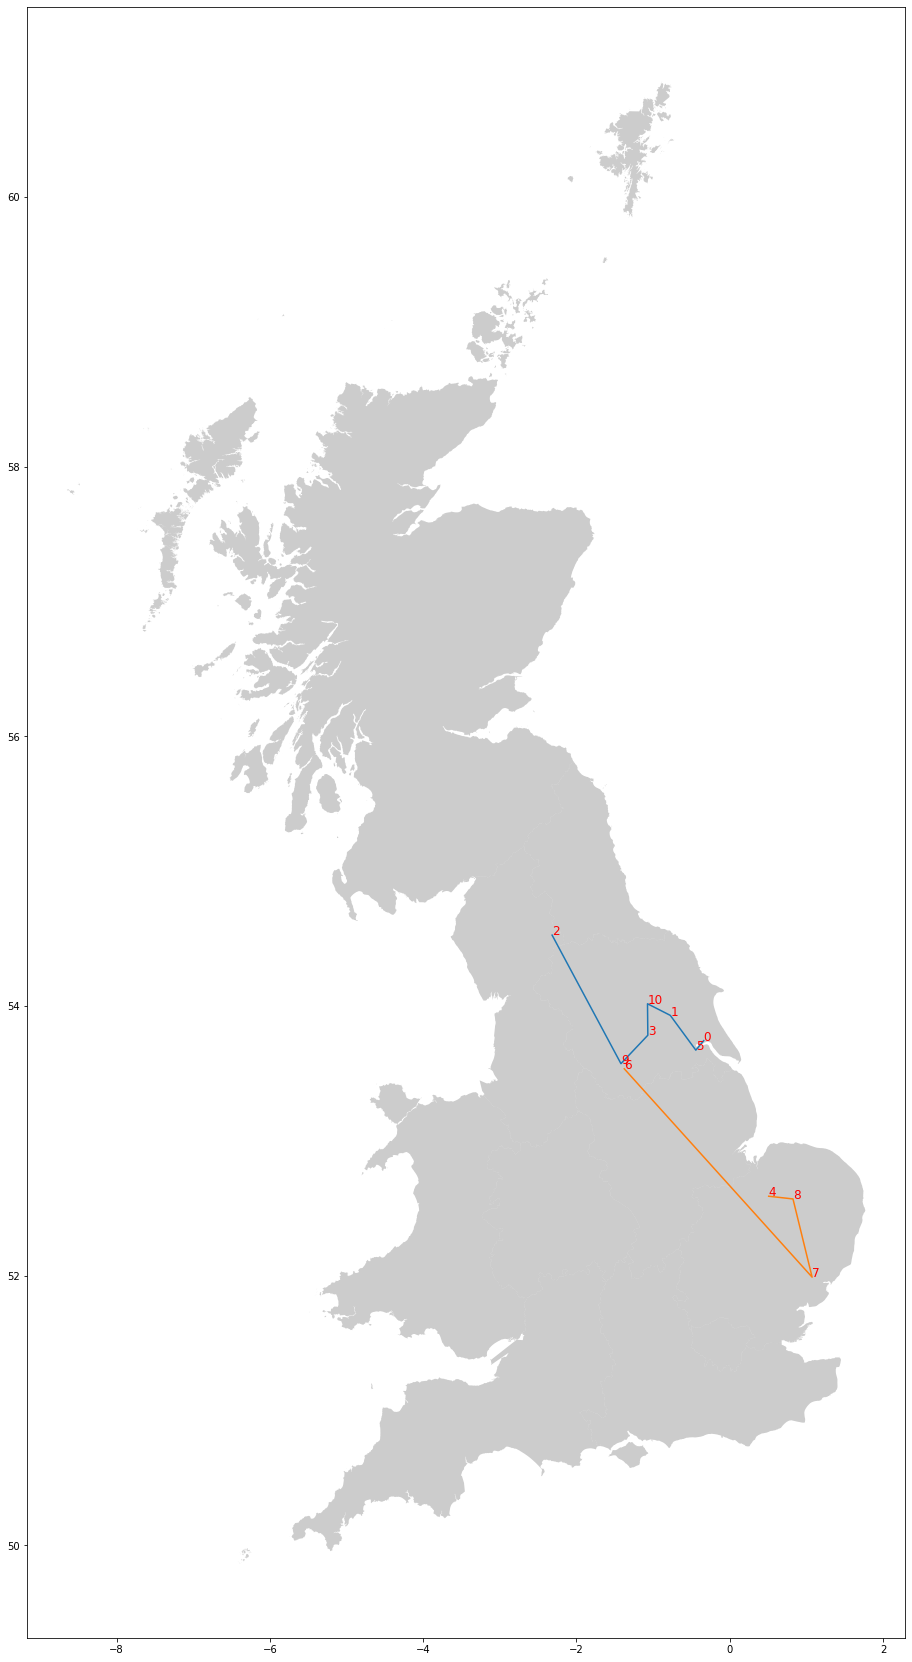

In [109]:
plot_routes(solutionsGA.path,points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)

In [13]:
vehicle_routes = []
vehicle_stops = []
vehicle_stop_demands = []
for v_route in solutions.path:
    vehicle_stop_demands.append(np.array(customer_demands)[v_route[1:]])
    vehicle_stops.append(points_coordinate[v_route[1:]])
    vehicle_routes.append(decode_routes(generate_routes(points_coordinate[v_route],api)))

100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


In [142]:
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

3

In [14]:
import folium
from folium.plugins import PolyLineTextPath
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

centerpoint = [np.mean(points_coordinate[:,0]),np.mean(points_coordinate[:,1])]

folium_map = folium.Map(location=centerpoint, tiles='openstreetmap', zoom_start=8)

# Create popups for the pickup-points
position_popups = []
for solution_path,stop_demands in zip(solutions.path,vehicle_stop_demands):
    position_popups.append(["Node: {}\nDemand: {}(kg)".format(node_id,node_demand) for node_id,node_demand in zip(solution_path[1:],stop_demands)])


markerCluster = MarkerCluster().add_to(folium_map)
# Add pickup-points and start positions to map
for startPos,stop_demands,stop_pos in zip(starts,position_popups,vehicle_stops):
    folium.Marker(location=list(points_coordinate[startPos]),popup="Startpos\nNode: {}".format(startPos),icon=folium.Icon(color='red', icon_color='white', icon='truck', angle=0, prefix='fa')).add_to(markerCluster)
    if len(stop_pos)>1:

        MarkerCluster(stop_pos[:-1],popups=stop_demands[:-1]).add_to(folium_map)
        folium.Marker(location=list(stop_pos[-1]),popup="End\n{}".format(stop_demands[-1]),
                      icon=folium.Icon(color='green', icon_color='white', icon='flag-checkered', angle=0, prefix='fa')).add_to(markerCluster)
        
    else:
        folium.Marker(location=list(stop_pos[0]),popup="{}".format(stop_demands[0]),
                      icon=folium.Icon(color='red', icon_color='white', icon='exclamation-circle', angle=0, prefix='fa')).add_to(markerCluster)
        

colormap = folium.branca.colormap.LinearColormap(colors=['red','green', 'blue'],index=[0,int(len(vehicle_routes)/2),len(vehicle_routes)])
# Add routes to map with popups
for index,(route,route_load,route_fuel_consumption, route_distance) in enumerate(zip(vehicle_routes,solutions.vehicle_loads,
                                                                                     solutions.vehicle_fuel_consumptions,solutions.vehicle_route_distances)):
    
    if(len(route) > 1):
        line = folium.PolyLine(route,color=colormap(index),
                               popup="Route Load: {}(kg)\nFuel consumption: {}(L)\nDistance: {}(km)".format(route_load,route_fuel_consumption,round(route_distance/1000,2))).add_to(folium_map)
        PolyLineTextPath(line, "\u27A4    ",repeat=True).add_to(folium_map)        

# Display the map
folium_map

0
1
